In [24]:

import pandas as pd
import tensorflow as tf
import torch
import numpy as np
import time
import datetime
import random
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

from google.colab import drive

!pip install transformers
import transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    device = torch.device("cuda")
    print('GPU:', torch.cuda.get_device_name(0))
else:
    raise SystemError('GPU device not found')

GPU: Tesla T4


In [26]:
data = pd.read_csv('labels.csv')

In [27]:
labels = pd.concat([data.drop('label', axis=1), data['label'].str.get_dummies('#')], axis=1)
labels.head()

,id,text,date,user,rt,fav,followers,verified,Gerçek,Negatif,Nötr,Pozitif,Yargı
0,221221,Yıl 2020 Bist100 tarafında bilanço dönemi ve ...,2022-07-11 13:38:08+00:00,borsaparatic,17,180,220342,False,0,0,0,1,1
1,221222,Bloomberg Businessweek’in 3 Temmuz tarihli öze...,2022-07-10 10:16:06+00:00,ibrahim___ethem,20,343,136873,False,1,0,0,1,0
2,221223,"en UCUZ #BIST 100 #hisse'leri\n#SAHOL 18,68&gt...",2022-07-09 20:53:12+00:00,ASIM_YALCINKAYA,107,934,138759,False,1,0,0,1,0
3,221224,Kısa notlarımı paylaşmaya başlıyorum.\nBayramd...,2022-07-09 19:44:59+00:00,ibrahim___ethem,134,1529,136873,False,0,0,0,1,1
4,221225,📍İstanbul Havalimanı dün tarihinin en yüksek u...,2022-07-09 07:01:24+00:00,ibrahim___ethem,23,379,136873,False,1,0,1,0,0


In [28]:
len(labels[labels['Gerçek'] == 1]), len(labels[labels['Yargı'] == 1])

(746, 639)

In [29]:
bin = labels.drop(['Pozitif', 'Negatif', 'Nötr', 'Yargı'], axis=1)

In [30]:
# rename column
# 1 for fact, zero for opinion
bin.rename(columns={'Gerçek': 'label'}, inplace=True)
bin.head()

,id,text,date,user,rt,fav,followers,verified,label
0,221221,Yıl 2020 Bist100 tarafında bilanço dönemi ve ...,2022-07-11 13:38:08+00:00,borsaparatic,17,180,220342,False,0
1,221222,Bloomberg Businessweek’in 3 Temmuz tarihli öze...,2022-07-10 10:16:06+00:00,ibrahim___ethem,20,343,136873,False,1
2,221223,"en UCUZ #BIST 100 #hisse'leri\n#SAHOL 18,68&gt...",2022-07-09 20:53:12+00:00,ASIM_YALCINKAYA,107,934,138759,False,1
3,221224,Kısa notlarımı paylaşmaya başlıyorum.\nBayramd...,2022-07-09 19:44:59+00:00,ibrahim___ethem,134,1529,136873,False,0
4,221225,📍İstanbul Havalimanı dün tarihinin en yüksek u...,2022-07-09 07:01:24+00:00,ibrahim___ethem,23,379,136873,False,1


In [31]:
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-turkish-128k-uncased', do_lower_case=True)
sentences = bin.text.values
max_len = 250

In [32]:
training = bin.groupby('label').apply(lambda x : x.sample(frac = 0.8))
test = pd.concat([bin,training]).drop_duplicates(keep=False)

print("Training: ", len(training))
print("Test: ", len(test))

training_texts = training.text.values

Training:  1120
Test:  280


In [33]:
len(training[training['label'] == 1]), len(training[training['label'] == 0])

(597, 523)

In [34]:
len(test[test['label'] == 1]), len(test[test['label'] == 0])

(149, 131)

In [35]:
training_labels = training.label.values

In [36]:
input_ids = []
attention_masks = []

for text in training_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True,
                        max_length = max_len,      
                        pad_to_max_length = True,
                        return_attention_mask = True, 
                        return_tensors = 'pt',
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(training_labels)

print('Original: ', training_texts[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  #petkm 8,50 yi alırsa saatlik macd tam sona gelecek.

8,54 ü de alırsa net kırılım olur.
Token IDs: tensor([    2,     7,  4286, 17762,    28,    16,  3603,  3553, 34205, 10925,
         7270,  1020,  2795,  5187,  3658,    18,    28,    16,  7186,    63,
         1961, 34205,  3542, 17459,  1982,  2544,    18,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   

In [37]:
train_dataset = TensorDataset(input_ids, attention_masks, labels)

batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size 
        )

number_of_categories = len(bin['label'].unique())

model = BertForSequenceClassification.from_pretrained(
    "dbmdz/bert-base-turkish-128k-uncased",
    num_labels = number_of_categories, 
    output_attentions = False,
    output_hidden_states = False,
)
# 
model.cuda()

Some weights of the model checkpoint at dbmdz/bert-base-turkish-128k-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassificatio

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(128000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [38]:
epochs = 4

optimizer = AdamW(model.parameters(),
                  lr = 5e-5,
                  eps = 1e-8 
                )

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [39]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

seed_val = 1903

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 10 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        
        output = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels)
        loss = output['loss']
        logits = output['logits']
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print("Average training loss: {0:.2f}".format(avg_train_loss))
    print("Training epoch took: {:}".format(training_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
        }
    )

print("Training completed in {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

======== Epoch 1 / 4 ========
Batch    10  of     35.    Elapsed: 0:00:13.
Batch    20  of     35.    Elapsed: 0:00:27.
Batch    30  of     35.    Elapsed: 0:00:40.
Average training loss: 0.35
Training epoch took: 0:00:47
======== Epoch 2 / 4 ========
Batch    10  of     35.    Elapsed: 0:00:14.
Batch    20  of     35.    Elapsed: 0:00:29.
Batch    30  of     35.    Elapsed: 0:00:43.
Average training loss: 0.20
Training epoch took: 0:00:50
======== Epoch 3 / 4 ========
Batch    10  of     35.    Elapsed: 0:00:14.
Batch    20  of     35.    Elapsed: 0:00:28.
Batch    30  of     35.    Elapsed: 0:00:42.
Average training loss: 0.12
Training epoch took: 0:00:49
======== Epoch 4 / 4 ========
Batch    10  of     35.    Elapsed: 0:00:14.
Batch    20  of     35.    Elapsed: 0:00:29.
Batch    30  of     35.    Elapsed: 0:00:43.
Average training loss: 0.08
Training epoch took: 0:00:50
Training completed in 0:03:17 (h:mm:ss)


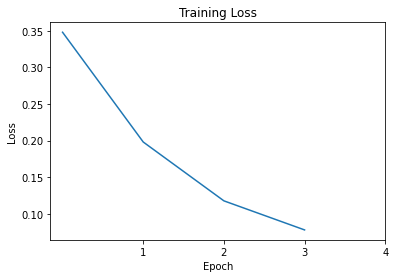

In [40]:
df_stats = pd.DataFrame(data=training_stats)
plt.plot(df_stats['Training Loss'], label="Training")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks([1, 2, 3, 4])
plt.show()

In [46]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Training Time
epoch,,
1,0.35,0:00:47
2,0.20,0:00:50
3,0.12,0:00:49
4,0.08,0:00:50


In [41]:

test_texts = test.text.values
test_labels = test.label.values

input_ids = []
attention_masks = []

for text in test_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True, 
                        max_length = max_len,          
                        pad_to_max_length = True,
                        return_attention_mask = True,  
                        return_tensors = 'pt',   
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(test_labels)

batch_size = 32  

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [42]:
print('Prediction started on test data')
model.eval()
predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  predictions.append(logits)
  true_labels.append(label_ids)

print('Prediction completed')

prediction_set = []

for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  prediction_set.append(pred_labels_i)

prediction_scores = [item for sublist in prediction_set for item in sublist]

Prediction started on test data
Prediction completed


In [48]:
test['prediction'] = prediction_scores

In [49]:
test.head()

,id,text,date,user,rt,fav,followers,verified,label,prediction
2,221223,"en UCUZ #BIST 100 #hisse'leri\n#SAHOL 18,68&gt...",2022-07-09 20:53:12+00:00,ASIM_YALCINKAYA,107,934,138759,False,1,1
8,221229,Malum 3 site taraması CUMA\nGÜÇLÜ AL &amp; AL ...,2022-07-07 19:16:07+00:00,ASIM_YALCINKAYA,10,132,138759,False,0,0
18,221239,#ALKIM #ASELS #CMBTN #EGGUB #GUBRF #ISGSY #TCE...,2022-07-07 07:33:40+00:00,Piri_KAPTAN,9,251,135214,False,0,0
19,221240,"🚨HSBC, Ereğli ve Kardemir için tavsiyelerini k...",2022-07-07 06:59:36+00:00,kursadbucak,10,350,156030,False,1,1
21,221242,Bugün devam ettirdiğim alımlarla alım hisse ma...,2022-07-06 19:05:20+00:00,kursadbucak,58,1089,156030,False,1,1


In [43]:
f_score = f1_score(test_labels, prediction_scores, average='macro')
precision = precision_score(test_labels, prediction_scores, average='macro')
recall = recall_score(test_labels, prediction_scores, average='macro')

print("F-Score: ", f_score)
print("Recall: ", recall)
print("Precision: ", precision)

report = pd.DataFrame(classification_report(test_labels, prediction_scores, output_dict=True))
report = report.rename(columns={'0':'Yargı',
                          '1':'Gerçek'})

print(report)

F-Score:  0.9065660454848812
Recall:  0.905835339925201
Precision:  0.9076733055426895
                Yargı      Gerçek  accuracy   macro avg  weighted avg
precision    0.913386    0.901961  0.907143    0.907673      0.907306
recall       0.885496    0.926174  0.907143    0.905835      0.907143
f1-score     0.899225    0.913907  0.907143    0.906566      0.907038
support    131.000000  149.000000  0.907143  280.000000    280.000000


In [51]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')

In [55]:
def preprocessing(input_text, tokenizer):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
  return tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True, 
                        max_length = max_len,          
                        pad_to_max_length = True,
                        return_attention_mask = True,  
                        return_tensors = 'pt',   
                   )

In [56]:
new_sentence = '#ASELS hissesi kısa zaman içinde yükselişe geçecek. ytd'

# We need Token IDs and Attention Mask for inference on the new sentence
test_ids = []
test_attention_mask = []

# Apply the tokenizer
encoding = preprocessing(new_sentence, tokenizer)

# Extract IDs and Attention Mask
test_ids.append(encoding['input_ids'])
test_attention_mask.append(encoding['attention_mask'])
test_ids = torch.cat(test_ids, dim = 0)
test_attention_mask = torch.cat(test_attention_mask, dim = 0)

# Forward pass, calculate logit predictions
with torch.no_grad():
  output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

prediction = 'Gerçek' if np.argmax(output.logits.cpu().numpy()).flatten().item() == 1 else 'Yargı'

print('Input Sentence: ', new_sentence)
print('Predicted Class: ', prediction)

Input Sentence:  #ASELS hissesi kısa zaman içinde yükselişe geçecek. ytd
Predicted Class:  Yargı


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
